# **AI In Industry Fall 2024**
### Heart Disease Classification on Different Models

Raymond House  
Miguel Blas Revert  
Diego Muñoz García

Dataset used: https://archive.ics.uci.edu/dataset/45/heart+disease

# Library Imports

In [1]:
# pip install ucimlrepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import numpy as np

# Dataset Import

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X_df = heart_disease.data.features 
y_df = heart_disease.data.targets

# print all columns in features
print(X_df.columns)
# print all columns in targets
print(y_df.columns)


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
Index(['num'], dtype='object')


# Attribute Descriptions
| **Attribute**      | **Description**                                                                                     | **Significance in Heart Disease Prediction**                                                                                                                                                                      |
|---------------------|-----------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **age**            | Age of the patient in years.                                                                        | Older age is a significant risk factor for heart disease due to physiological changes and comorbidities.                                                                  |
| **sex**            | Sex (1 = male; 0 = female).                                                                         | Men generally have a higher risk of heart disease compared to premenopausal women.                                                                                         |
| **cp**             | Chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic).    | Chest pain type is strongly indicative of heart disease; typical angina is a key symptom of coronary artery disease.                                                       |
| **trestbps**       | Resting blood pressure in mm Hg on admission.                                                       | High resting blood pressure (hypertension) is a well-known risk factor for cardiovascular diseases.                                                                       |
| **chol**           | Serum cholesterol level in mg/dl.                                                                   | Elevated cholesterol is associated with atherosclerosis and increases the risk of heart disease.                                                                          |
| **fbs**            | Fasting blood sugar (>120 mg/dl: 1 = true; 0 = false).                                              | High fasting blood sugar can indicate diabetes, a significant risk factor for heart disease.                                                                              |
| **restecg**        | Resting electrocardiographic results (0 = normal; 1 = ST-T wave abnormality; 2 = left ventricular hypertrophy). | Abnormal ECG readings can signify heart strain, ischemia, or hypertrophy, all of which are linked to heart disease.                                                      |
| **thalach**        | Maximum heart rate achieved during physical exertion.                                               | Lower maximum heart rate during exertion may indicate heart problems such as reduced cardiac output or ischemia.                                                         |
| **exang**          | Exercise-induced angina (1 = yes; 0 = no).                                                          | Exercise-induced angina suggests poor blood flow through coronary arteries and is a critical indicator of heart disease.                                                  |
| **oldpeak**        | ST depression induced by exercise relative to rest.                                                 | ST depression is a marker of ischemia (reduced blood supply to the heart).                                                                                               |
| **slope**          | Slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping).                   | A flat or downsloping ST segment during exercise is associated with ischemia and poor heart function.                                                                     |
| **ca**             | Number of major vessels (0-3) colored by fluoroscopy.                                               | A higher number of blocked vessels indicates severe coronary artery disease and is directly related to heart disease risk.                                                |
| **thal**           | Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect).                                   | Thalassemia results indicate the presence of defects or abnormalities in heart perfusion, which are indicators of heart disease.                                          |
| **num (target)**   | Diagnosis of heart disease (0 = no heart disease; 1 = heart disease).                                | The predicted attribute indicating whether the patient has significant heart disease based on >50% narrowing in any major vessel.                                         |

# Data Visualization

Identify which columns having missing values in our features dataframe.

In [3]:
for col in X_df.columns:
    # check if the column has any null or empty values
    count = X_df[col].isnull().sum()
    if count > 0:
        print(col, count)

# for each row in y_df, if value is greater than 1, set it to 1. dont use lambda
for i in range(len(y_df)):
    if y_df.iloc[i, 0] > 1:
        y_df.iloc[i, 0] = 1

y_df.value_counts()

ca 4
thal 2


C:\Users\raymo\AppData\Local\Temp\ipykernel_30672\1584981253.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df.iloc[i, 0] = 1


num
0      164
1      139
Name: count, dtype: int64

## Graph columns with missing values to determine how to fill
ca and thal.
ca is the number of major vessels colored by fluoroscopy. less than 3 indicates a blockage in at least 1.
thal is an indication of abnormalities in heart perfusion. 3 is normal, 6 is fixed defect, 7 is reversible defect.

In this section we will analyze their relationships with other features.

First we will graph frequency of both columns.

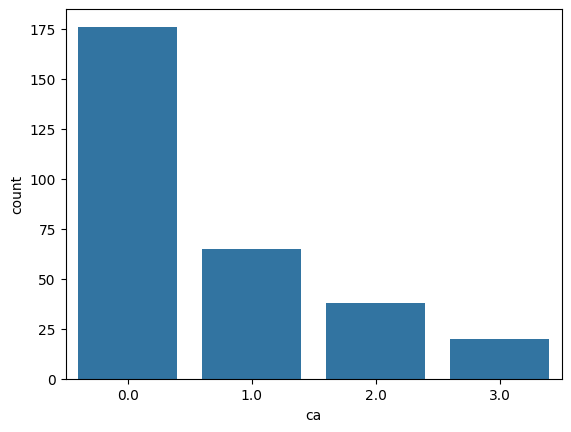

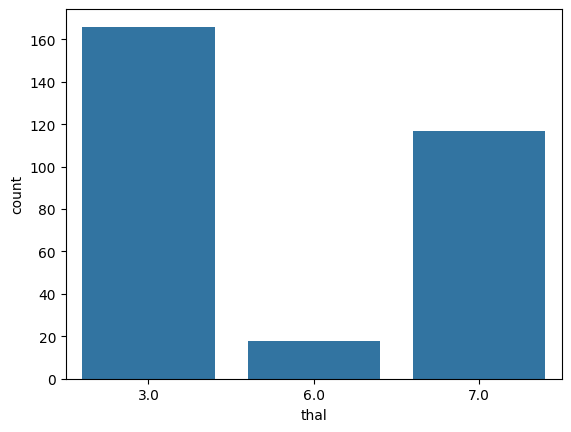

In [4]:
# bar graph for 'ca'
sns.countplot(x='ca', data=X_df)
plt.show()

# bar graph for 'thal'
sns.countplot(x='thal', data=X_df)
plt.show()

Now we will identify the relationships by plotting ca and thal against all other features. We will use the information from the countplots later to calculate the decision when filling data.

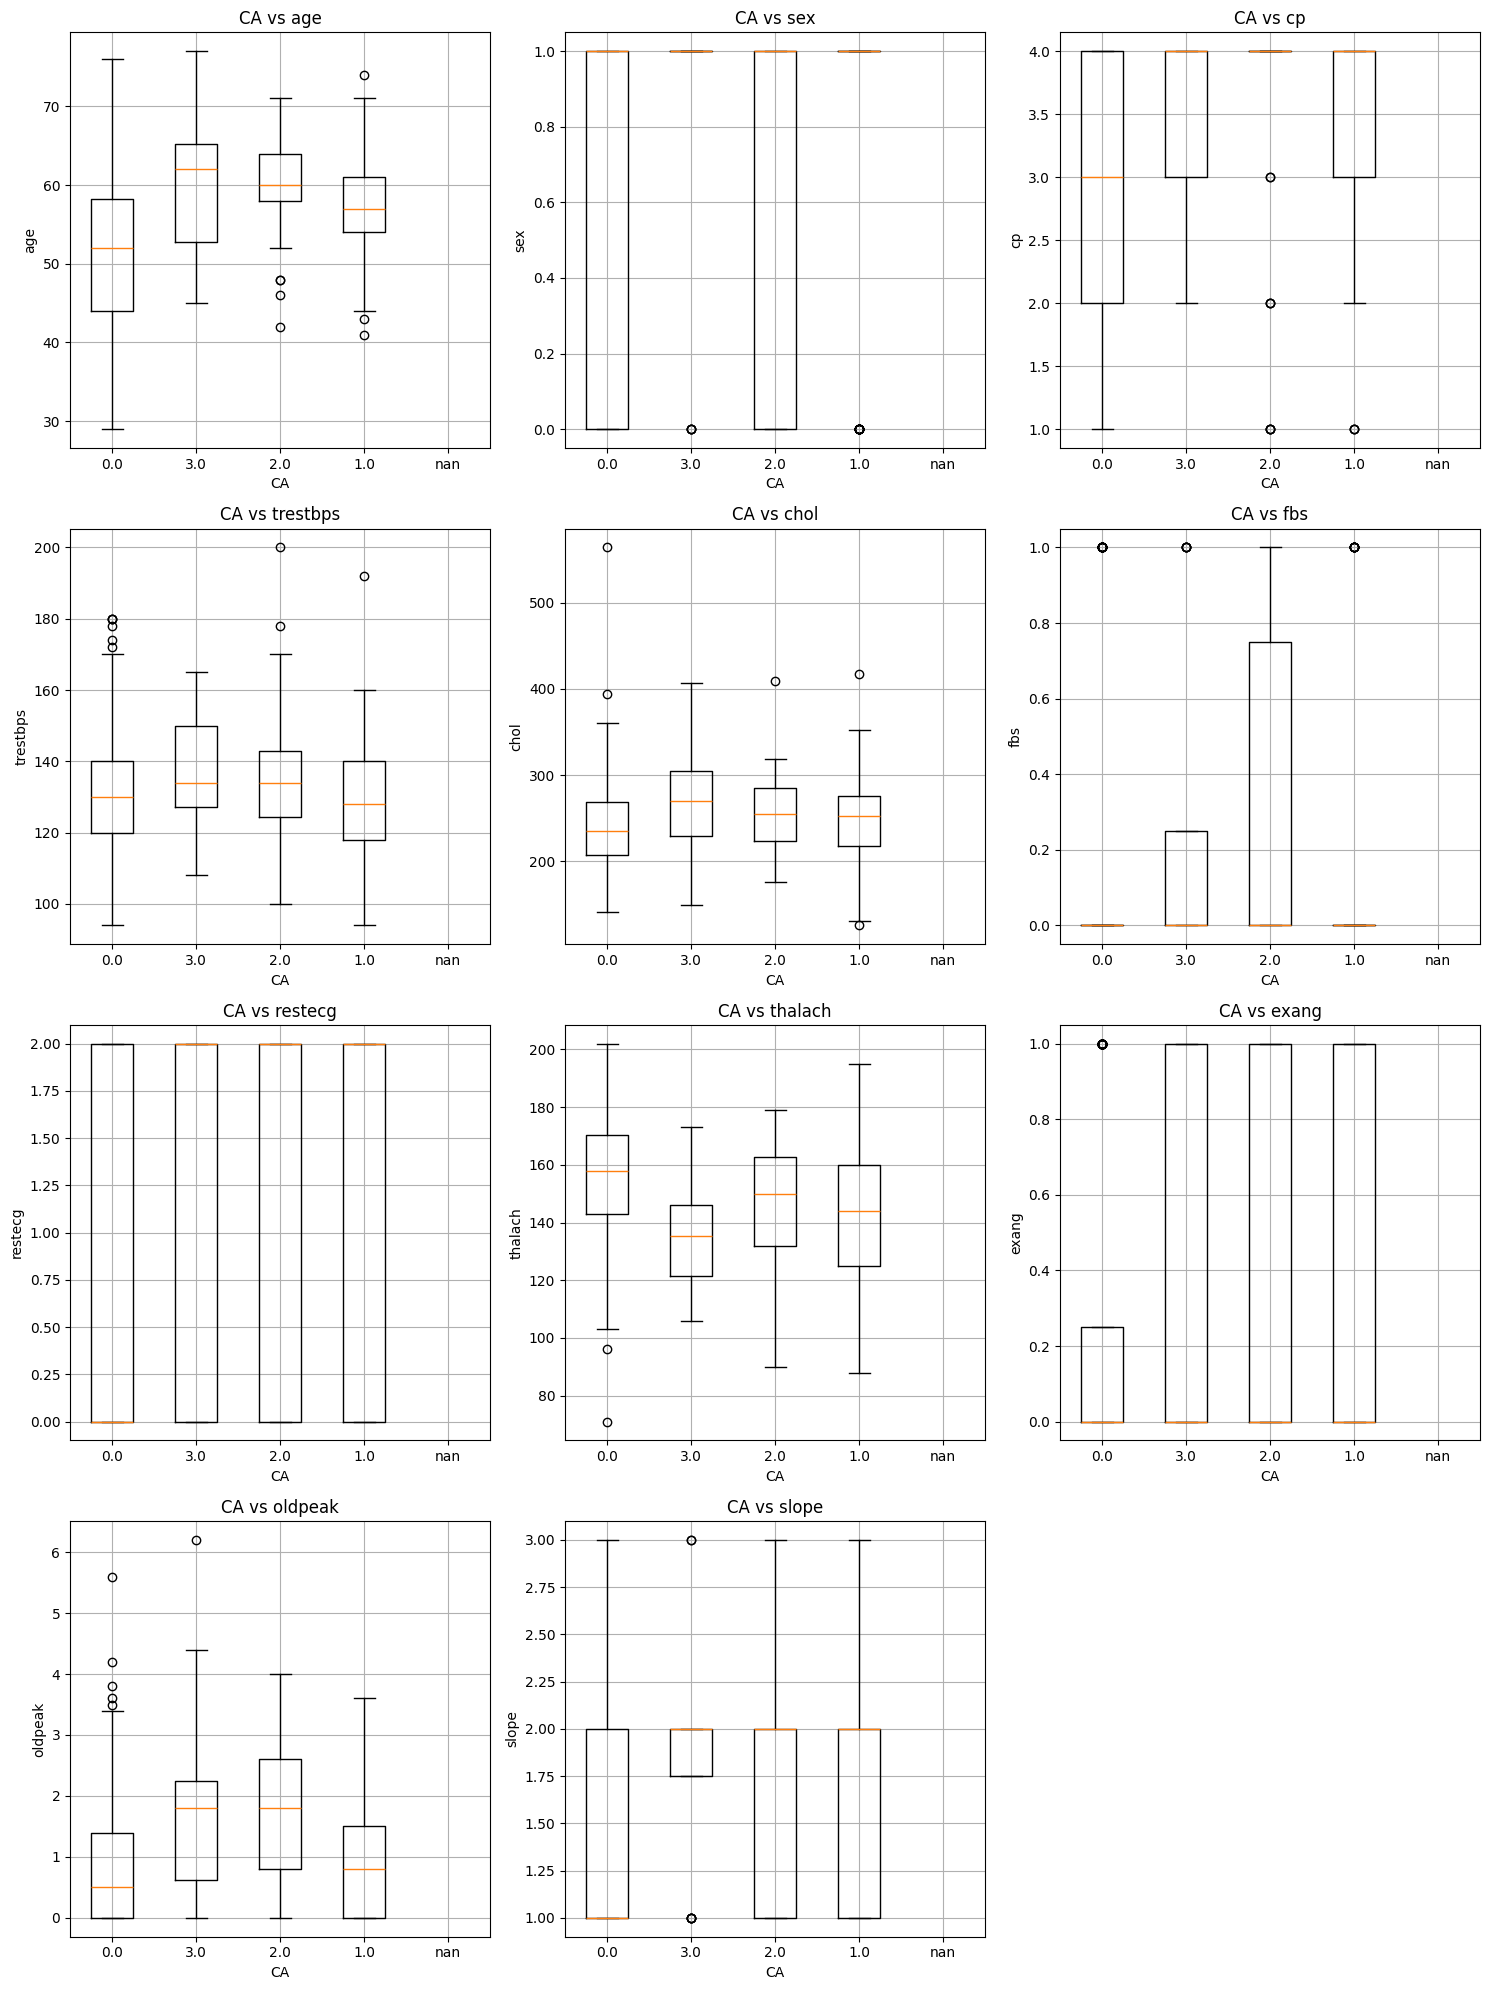

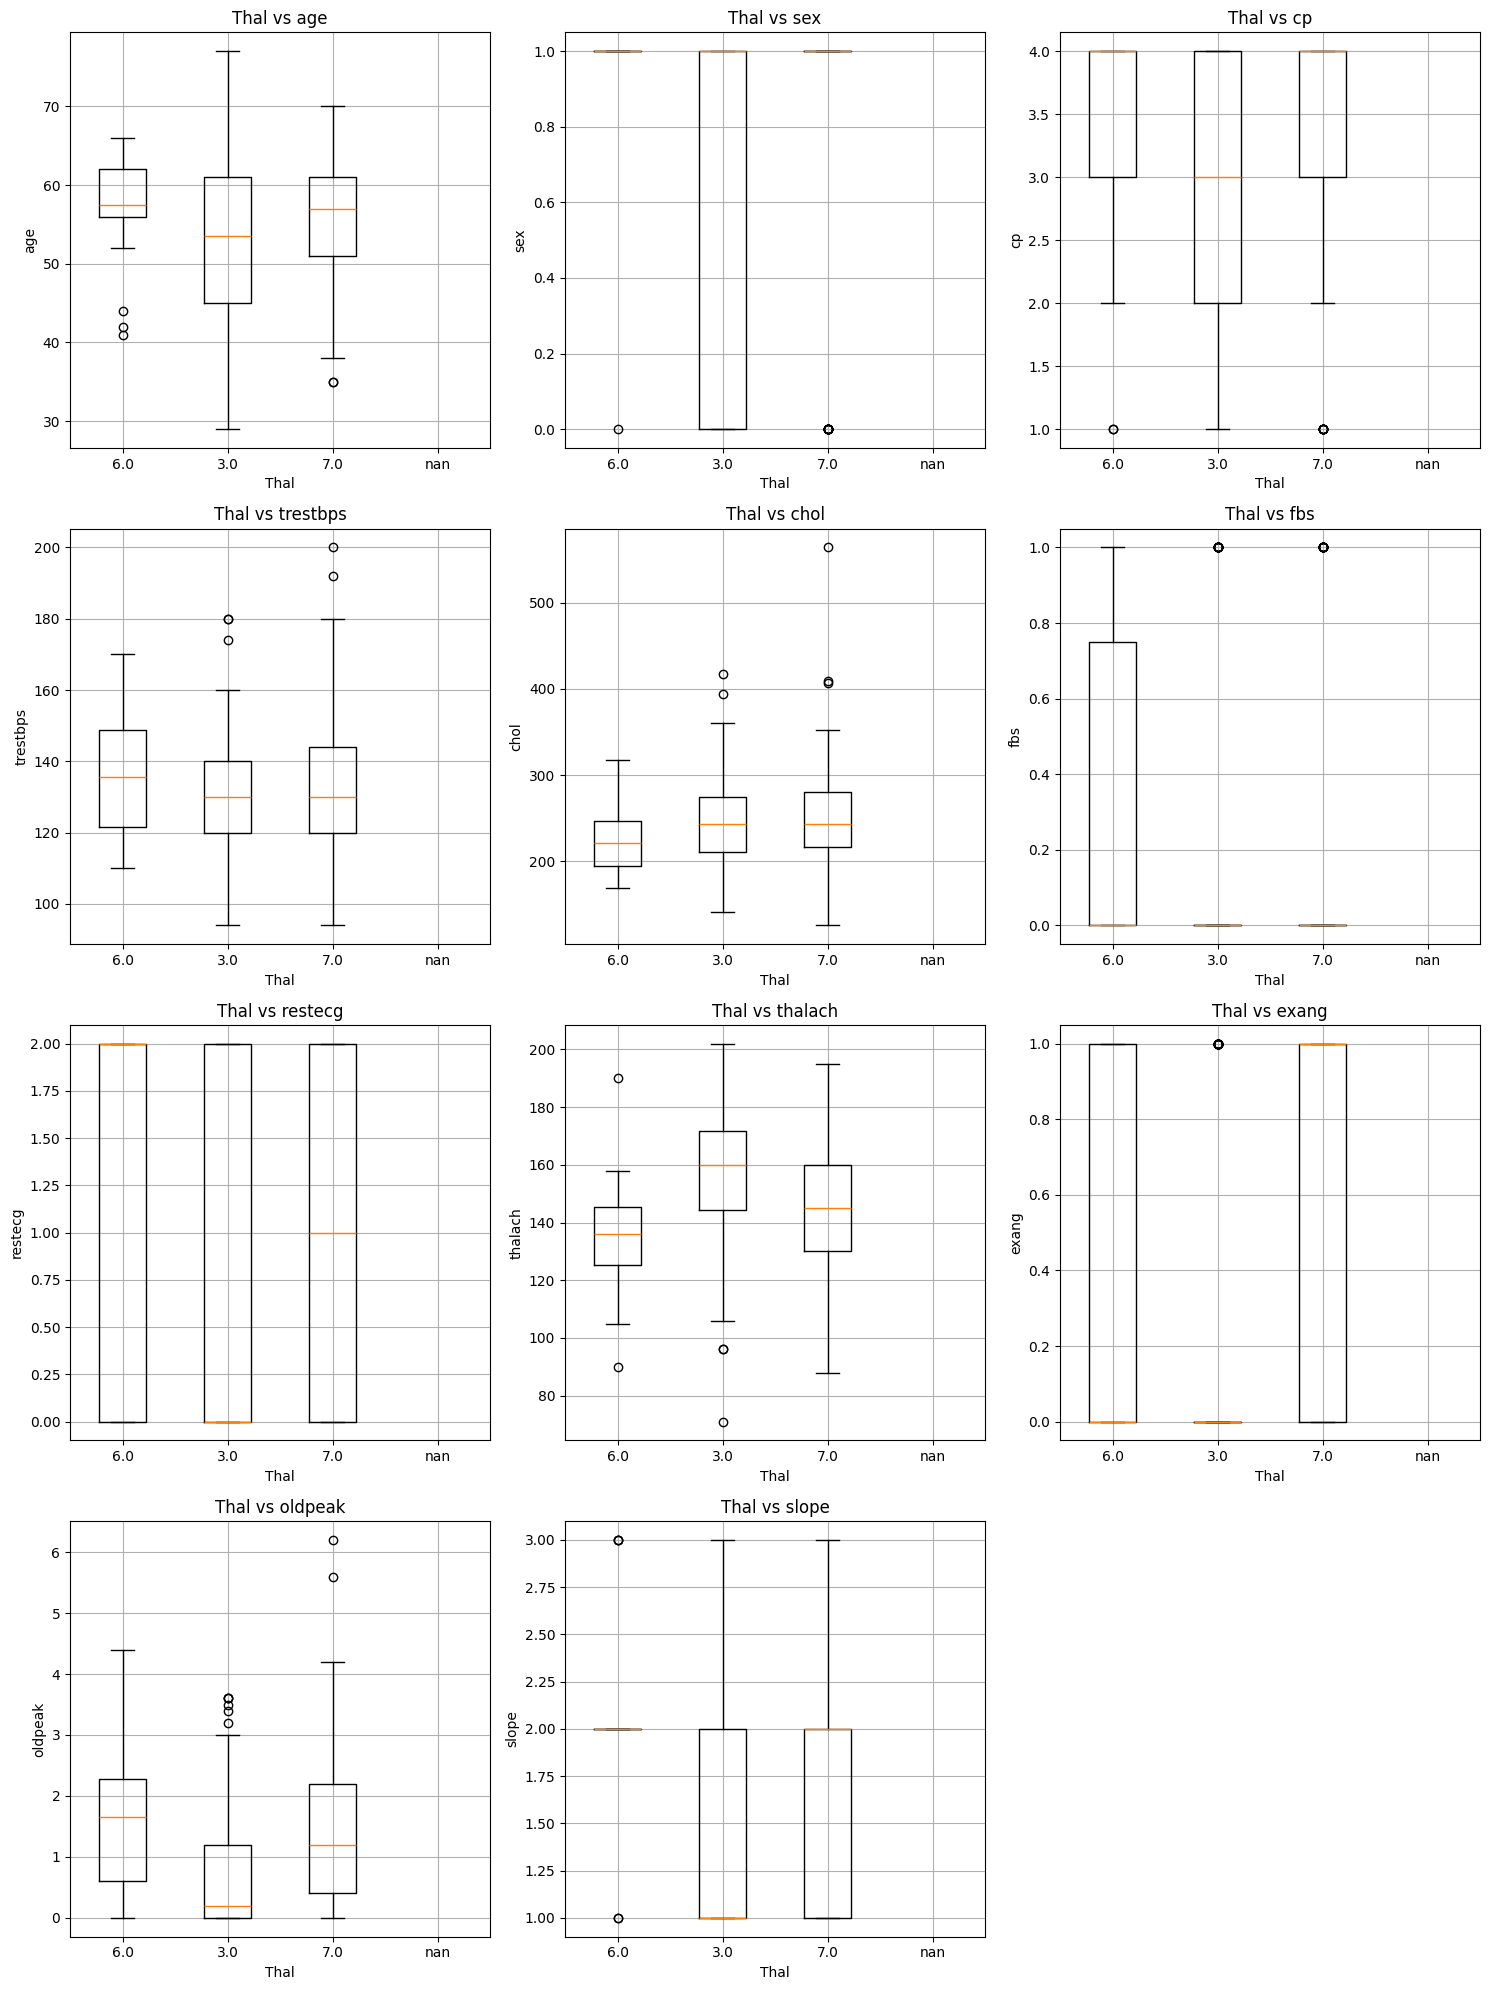

In [5]:
# Plot ca against all other columns except ca and thal
cols = [col for col in X_df.columns if col not in ['ca', 'thal']]

# Dynamically organize columns into rows for display
cols_per_row = 3
total_plots = len(cols)
rows = (total_plots + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 5))
axes = axes.flatten()
ca_unique = X_df['ca'].unique()

for i, col in enumerate(cols):
    ax = axes[i]
    
    # Group data by unique values in 'ca'
    grouped_data = [X_df.loc[X_df['ca'] == val, col] for val in ca_unique]
    ax.boxplot(grouped_data, tick_labels=ca_unique)

    ax.set_title(f'CA vs {col}')
    ax.set_xlabel('CA')
    ax.set_ylabel(col)
    ax.grid(True)

# hide unused subplots
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# plot Thal against all other columns except CA and Thal
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 5))
axes = axes.flatten()
thal_unique = X_df['thal'].unique()

for i, col in enumerate(cols):
    ax = axes[i]

    grouped_data = [X_df.loc[X_df['thal'] == val, col] for val in thal_unique]
    ax.boxplot(grouped_data, tick_labels=thal_unique)

    ax.set_title(f'Thal vs {col}')
    ax.set_xlabel('Thal')
    ax.set_ylabel(col)
    ax.grid(True)

# Hide unused subplots
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# use box plots because x axis categorical. indicated by the scatter plots being vertical lines. 
# CA vs sex for example, binary vs binary, show fractions for gender, helps understanding connection. maybe apply box plot / histogram 

## KNN Imputation approach to fill data
Since we have found a correlation between:

- _CA_ and age, trestbps, chol and thalach
- _Thal_ and age, trestbps, chol, thalach and oldpeak

We can use K-Nearest Neighbors Imputation to find similar rows of correlated data columns in order to fill our missing values.

_Why KNN ?_ It finds similar rows, meaning similar values for each relevant features and will fill it in. We found this highly relevant since there are a good amount of features in our dataset, and it also doesn't assume linear relationships or specific distributions-- it  looks at nearby/similar row values.

To optimize this, we could test for the optimal k value, although the count of missing data is not large.

In [6]:
ca_df_features = ['age', 'trestbps', 'chol', 'thalach', 'ca']
thal_df_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'thal']

# Impute missing values using KNN
ca_df = X_df[ca_df_features]
thal_df = X_df[thal_df_features]

thal_imputer = KNNImputer(n_neighbors=5)
ca_imputer = KNNImputer(n_neighbors=5)

ca_df_imputed = ca_imputer.fit_transform(ca_df)
thal_df_imputed = thal_imputer.fit_transform(thal_df)

ca_df_imputed = np.round(ca_df_imputed)

# round thal values to nearest: 3, 6 or 7:
for i in range(len(thal_df_imputed)):
    for j in range(len(thal_df_imputed[i])):
        if thal_df_imputed[i][j] < 4:
            thal_df_imputed[i][j] = 3
        elif thal_df_imputed[i][j] < 6:
            thal_df_imputed[i][j] = 6
        else:
            thal_df_imputed[i][j] = 7

thal_df_imputed = np.round(thal_df_imputed)

ca_df_imputed = pd.DataFrame(ca_df_imputed, columns=ca_df_features, index=ca_df.index)
thal_df_imputed = pd.DataFrame(thal_df_imputed, columns=thal_df_features, index=thal_df.index)

# replace the original columns with the imputed 'ca' column from ca_df_imputed, and 'thal' from thal_df_imputed
X_df0 = X_df.copy()
X_df0['ca'] = ca_df_imputed['ca']
X_df0['thal'] = thal_df_imputed['thal']

# Review shape of new dataset and graph
Check to confirm that there are less rows with empty fields and that the scatter plots do not have _new_ outliers.

In [7]:
for col in X_df0.columns:
    # check if the column has any null or empty values
    count = X_df0[col].isnull().sum()
    if count > 0:
        print(col, count)

Blue: Original Data
Red: Imputed Data


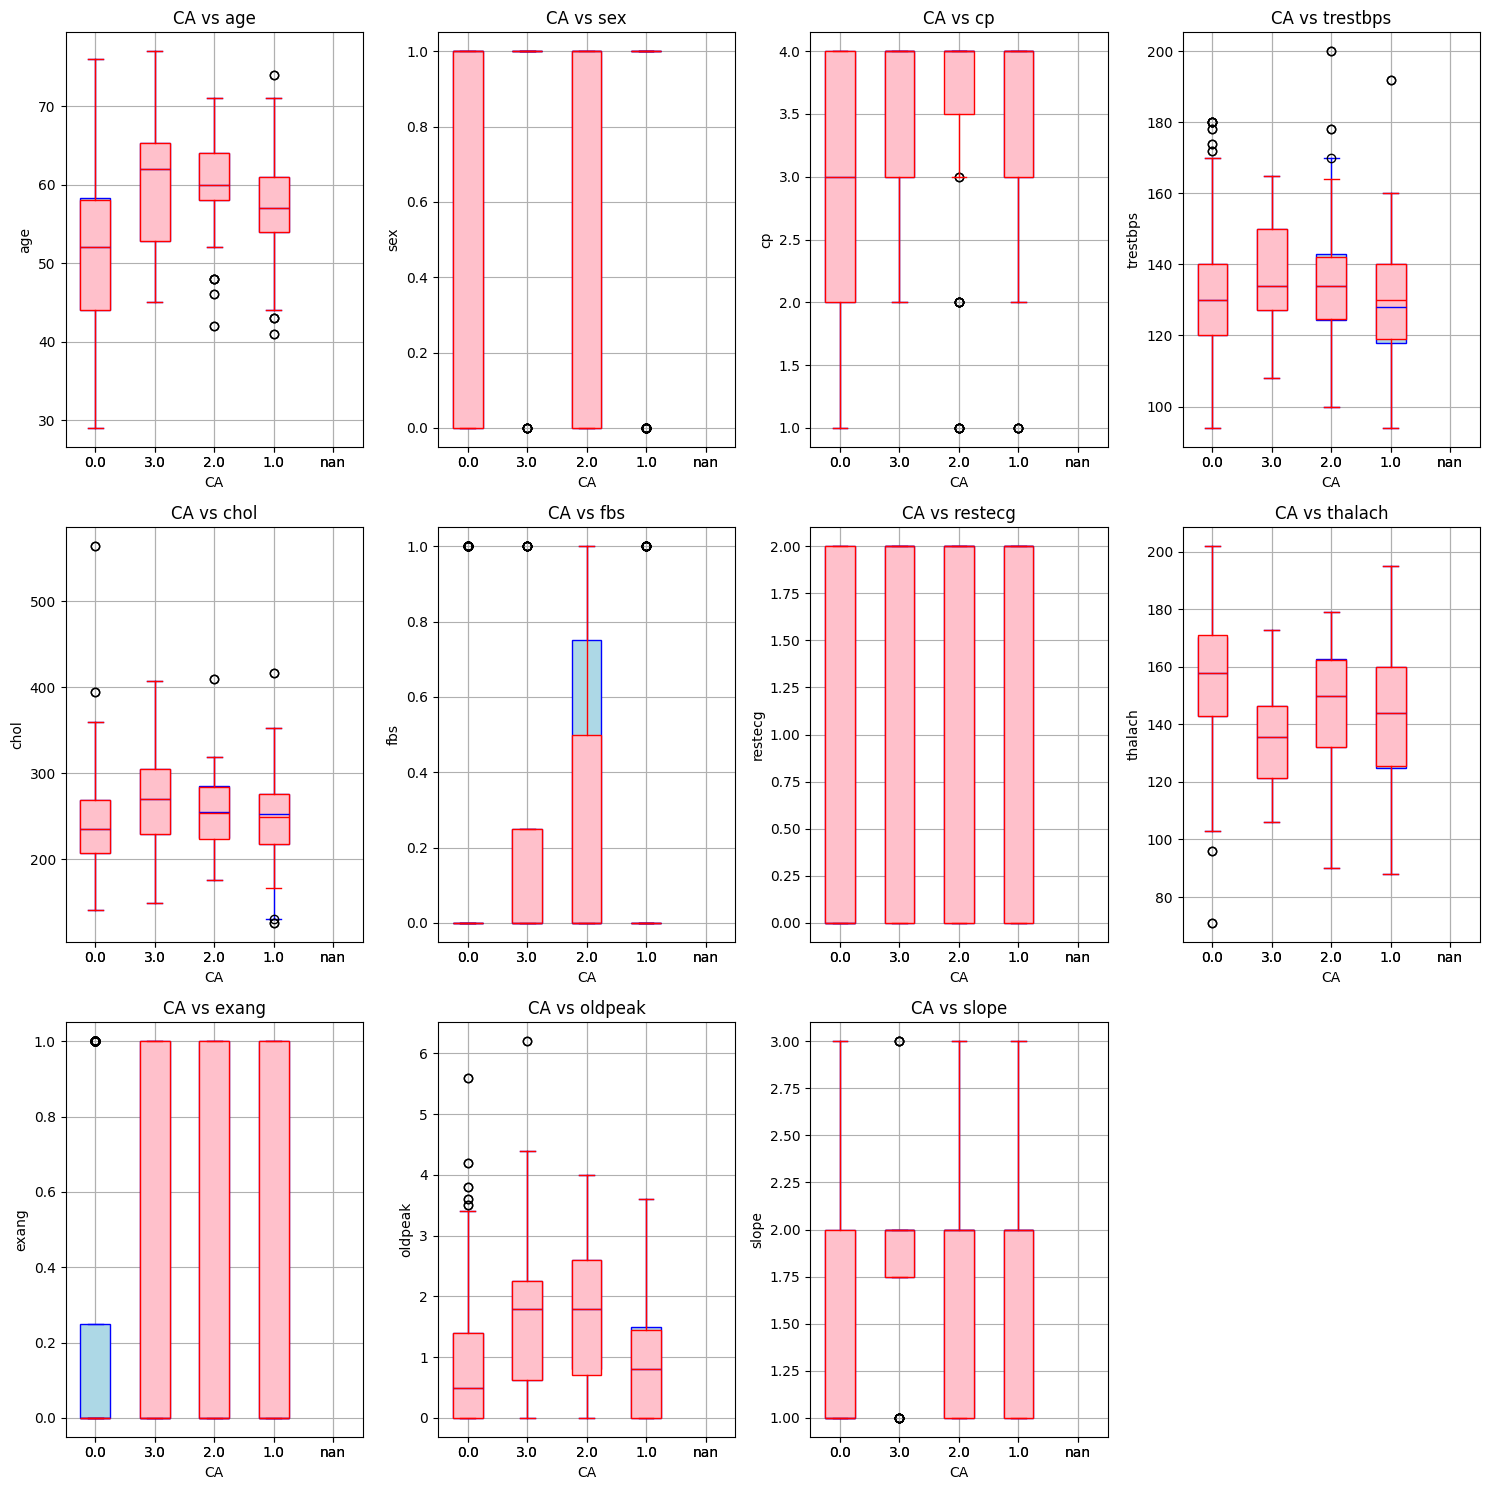

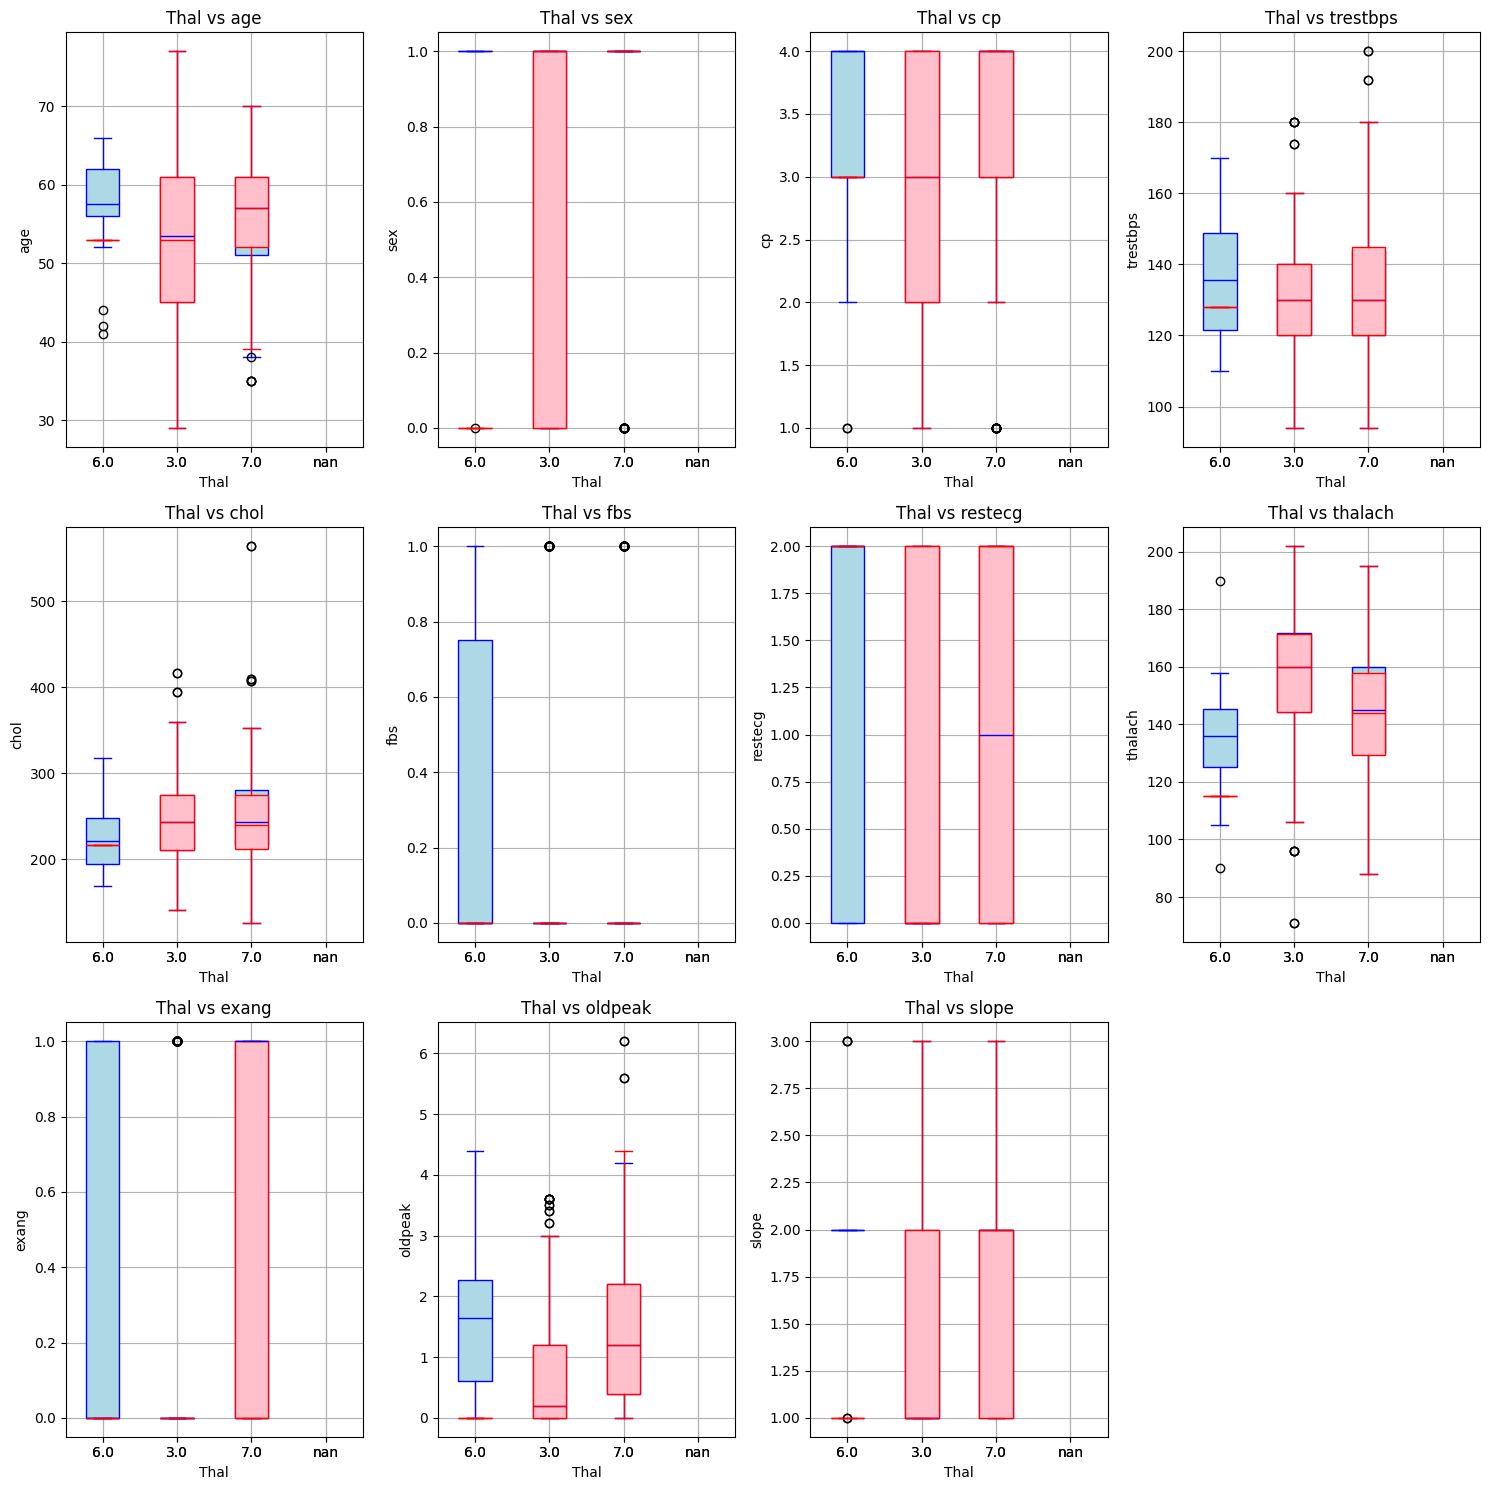

In [19]:
# Plot ca against all other columns except ca and thal
cols = [col for col in X_df.columns if col not in ['ca', 'thal']]

# dynamically organize columns into rows on display
cols_per_row = 4
total_plots = len(cols)
rows = (total_plots + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 5))
axes = axes.flatten()

ca_unique = X_df['ca'].unique()

thal_unique = X_df['thal'].unique()

print("Blue: Original Data")
print("Red: Imputed Data")

for i, col in enumerate(cols):
    ax = axes[i]

    # Group data by unique values in 'ca'
    grouped_data = [X_df.loc[X_df['ca'] == val, col] for val in ca_unique]
    ax.boxplot(grouped_data, 
               tick_labels=ca_unique,
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'))

    grouped_data = [X_df0.loc[X_df0['ca'] == val, col] for val in ca_unique]
    ax.boxplot(grouped_data, 
               tick_labels=ca_unique,
               patch_artist=True,
               boxprops=dict(facecolor='pink', color='red'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='red'),
                capprops=dict(color='red'))

    ax.set_title(f'CA vs {col}')
    ax.set_xlabel('CA')
    ax.set_ylabel(col)
    ax.grid(True)

# hide unused subplots
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# plot Thal against all other columns except CA and Thal
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 5))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]

    # Group data by unique values in 'thal'
    grouped_data = [X_df.loc[X_df['thal'] == val, col] for val in thal_unique]
    ax.boxplot(grouped_data, 
               tick_labels=thal_unique,
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'))

    grouped_data = [X_df0.loc[X_df0['thal'] == val, col] for val in thal_unique]
    ax.boxplot(grouped_data, 
               tick_labels=thal_unique,
               patch_artist=True,
               boxprops=dict(facecolor='pink', color='red'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='red'),
                capprops=dict(color='red'))

    ax.set_title(f'Thal vs {col}')
    ax.set_xlabel('Thal')
    ax.set_ylabel(col)
    ax.grid(True)

# Hide unused subplots
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Copy the X_df0 into X_df for clarity

In [17]:
# turn X_df into the contents of X_df0
X_df = X_df0.copy()

# Anomaly Detection
After handling missing data entries, we evaluate the data for anomalies that could be skewing our model and remove them before fitting our model(s).

Number of anomalies detected using Z-Score: 7
Number of anomalies detected using Isolation Forest: 15
Original dataset shape: (287, 13)
Cleaned dataset shape (Z-Score): (280, 13)
Cleaned dataset shape (Isolation Forest): (272, 13)


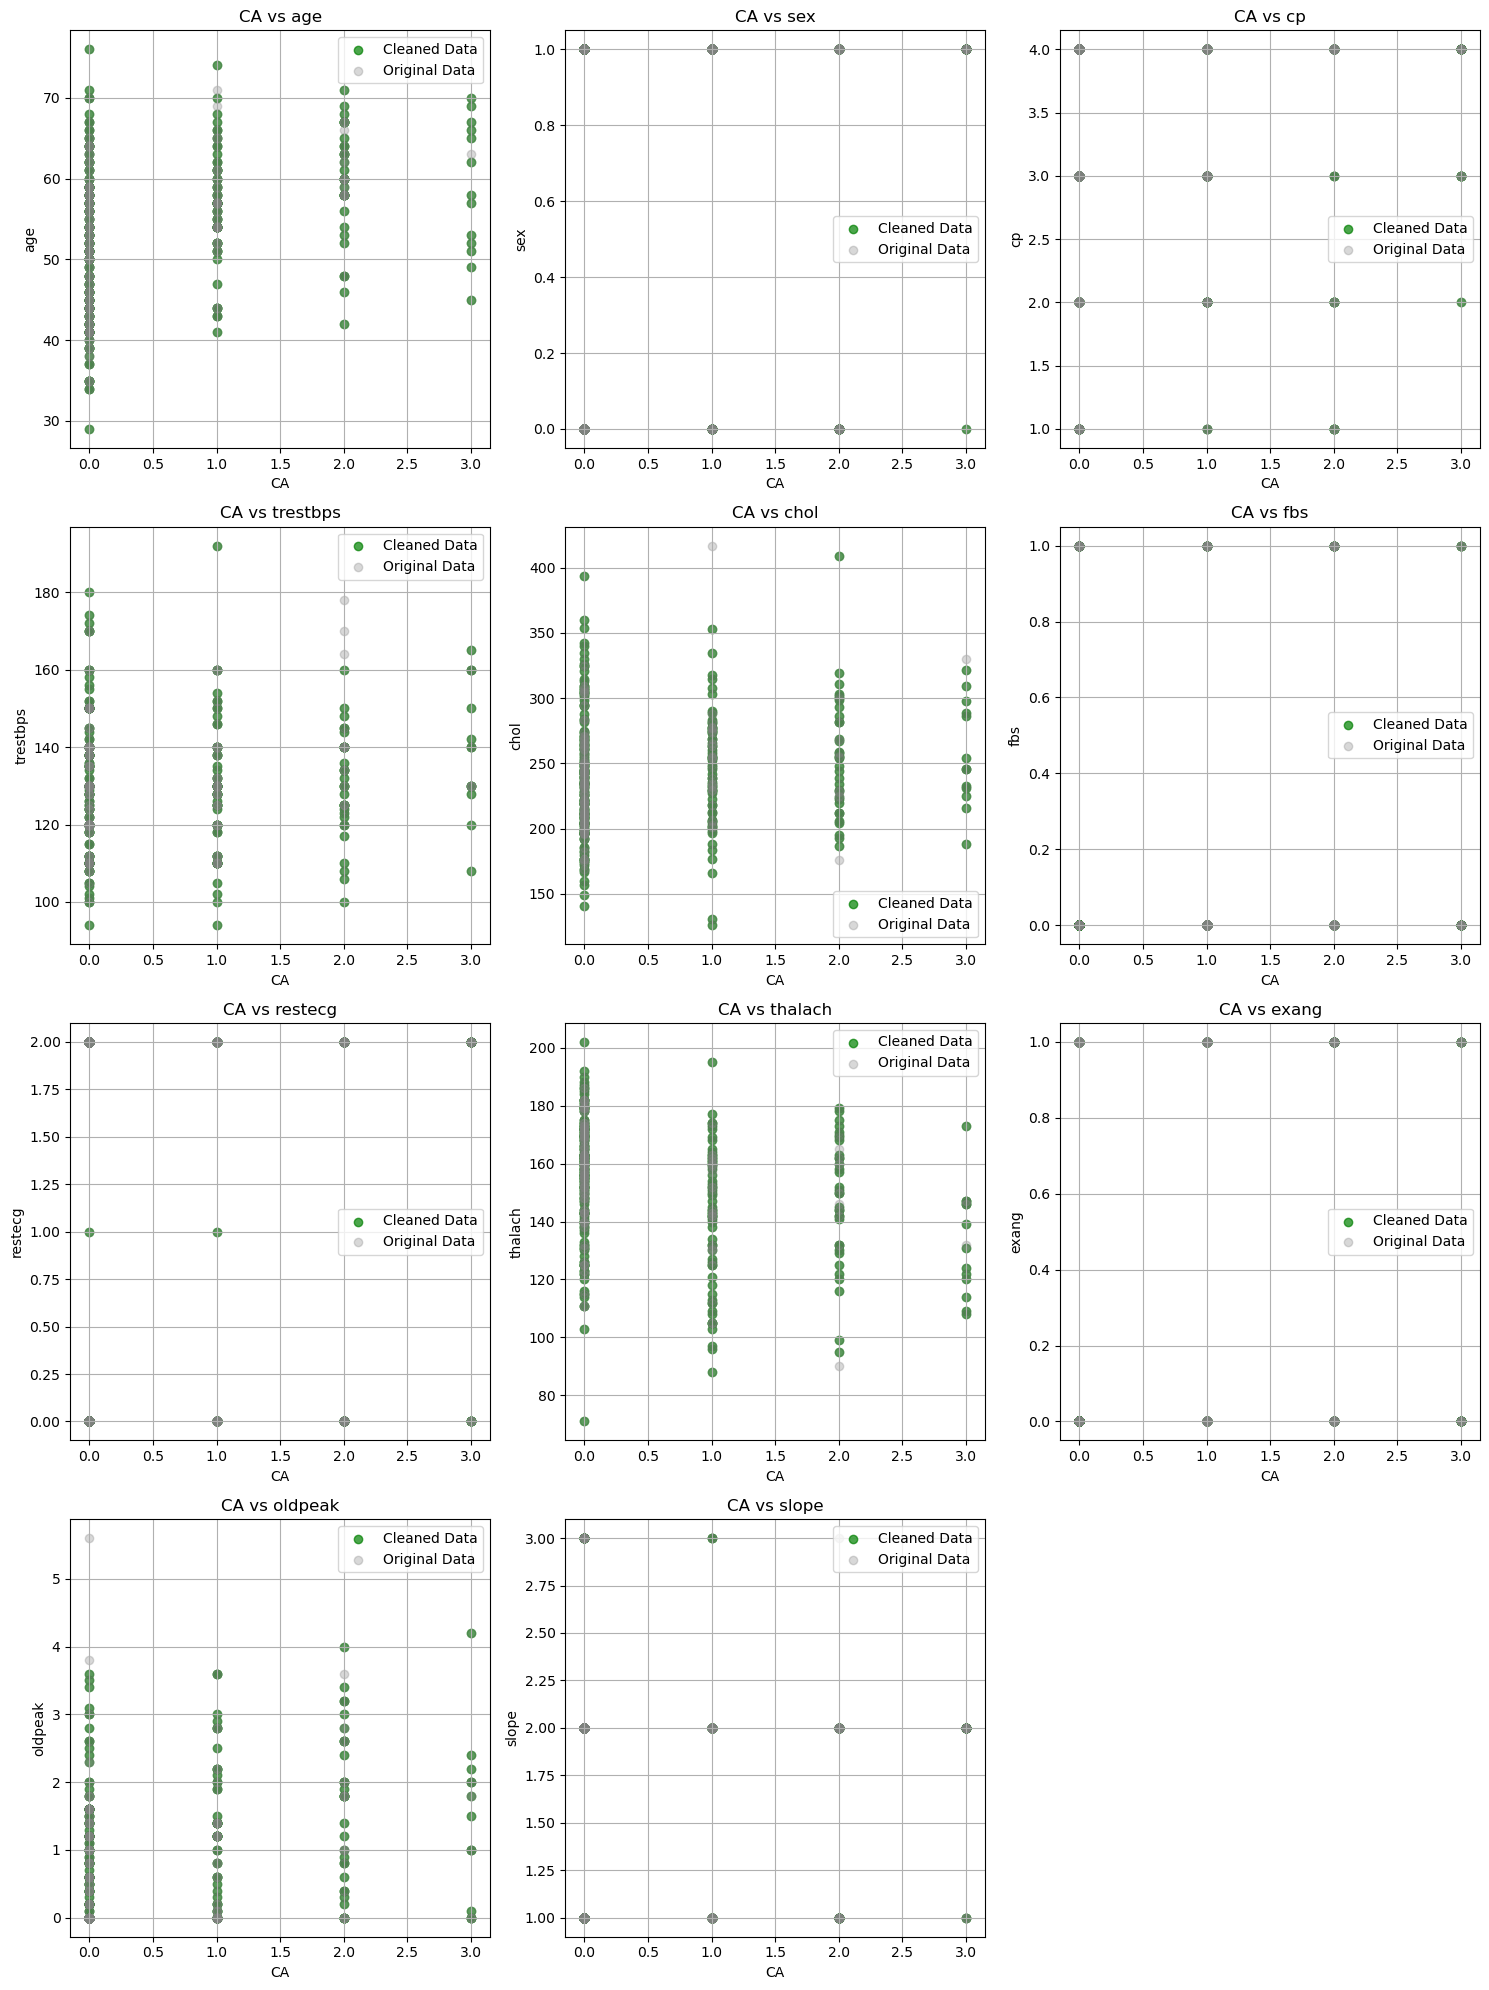

In [29]:
# Import required libraries for anomaly detection
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

# Define a function to identify anomalies based on Z-Score
def detect_anomalies_zscore(data, threshold=3):
    """
    Detects anomalies in the dataset using Z-score.
    Points with a Z-score greater than the threshold are considered anomalies.

    Parameters:
    data (pd.DataFrame): The dataset to check for anomalies.
    threshold (float): The Z-score threshold to identify anomalies.

    Returns:
    pd.DataFrame: A DataFrame indicating whether each row is an anomaly (True) or not (False).
    """
    z_scores = data.apply(zscore)  # Calculate Z-scores for each column
    anomalies = (z_scores.abs() > threshold).any(axis=1)  # Mark rows with any value exceeding the threshold
    return anomalies

# Detect anomalies using Z-Score
zscore_anomalies = detect_anomalies_zscore(X_df)

# Print number of anomalies detected
print(f"Number of anomalies detected using Z-Score: {zscore_anomalies.sum()}")

# Remove anomalies detected by Z-Score
X_df_cleaned_zscore = X_df[~zscore_anomalies].reset_index(drop=True)

# Use Isolation Forest to detect anomalies
def detect_anomalies_isolation_forest(data, contamination=0.05):
    """
    Detects anomalies in the dataset using Isolation Forest.

    Parameters:
    data (pd.DataFrame): The dataset to check for anomalies.
    contamination (float): The proportion of anomalies in the data.

    Returns:
    pd.Series: A series indicating whether each row is an anomaly (1) or not (-1).
    """
    # Initialize Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    
    # Fit the model and predict anomalies
    anomaly_labels = iso_forest.fit_predict(data)
    return anomaly_labels

# Detect anomalies using Isolation Forest
iso_forest_anomalies = detect_anomalies_isolation_forest(X_df)

# Print number of anomalies detected
print(f"Number of anomalies detected using Isolation Forest: {(iso_forest_anomalies == -1).sum()}")

# Remove anomalies detected by Isolation Forest
X_df_cleaned_iso_forest = X_df[iso_forest_anomalies == 1].reset_index(drop=True)

# Compare datasets
print(f"Original dataset shape: {X_df.shape}")
print(f"Cleaned dataset shape (Z-Score): {X_df_cleaned_zscore.shape}")
print(f"Cleaned dataset shape (Isolation Forest): {X_df_cleaned_iso_forest.shape}")

# Final cleaned dataset (choosing a method; here, Isolation Forest)
X_df_cleaned = X_df_cleaned_iso_forest

# Visualize cleaned data to verify anomalies are removed
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 5))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    # Scatter plot for the cleaned dataset
    ax.scatter(X_df_cleaned['ca'], X_df_cleaned[col], alpha=0.7, color='green', label='Cleaned Data')
    # Scatter plot for the original dataset
    ax.scatter(X_df['ca'], X_df[col], alpha=0.3, color='gray', label='Original Data')
    ax.set_title(f'CA vs {col}')
    ax.set_xlabel('CA')
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True)

# Hide unused subplots
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Try out different models and compare performance
- *Random Forest*:
Compilation of decision trees that vote on majority
- *Support Vector Machine(SVM)*:
Divides between separated groups, distinction between groups should exist
- *XGBoost*:
Decision trees, but learns from mistakes.

Compare model performance on certain metrics:
- 'rs' 'f1' 'p' 'rmse'

## Create train-test split
80/20 split, random_state 42

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

random_state = 42

# train test split 80/20 random state 42
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# create empty df to store metrics for each model.

(242, 13) (61, 13) (242, 1) (61, 1)


In [23]:
model_lbls = ['svc' # support vector classifier
             ,'xg'  # xgboost
             ,'rf'   # random forest
            ]

models = {
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
                },
            ]
          },
    'xg':{ 'name': 'XGBoost             ',
            'estimator': XGBClassifier(random_state=random_state),
            'param': [{'max_depth': [*range(4,10)]
                    ,'n_estimators':[*range(10,60,10)]
                    ,'learning_rate':[0.01, 0.1, 0.2]
                }
            ]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          }

}

# Random Forest Classifier

# Support Vector Machine

# XGBoost

# SHAP Method for Analysis

In [ ]:
# estimation made based on early data only, RUL cant really be used for this dataset

# classification, but why? (matters a lot in healthcare)

# The explainability method is called SHAP for biomedical analysis